In [78]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lib.io.stan
import importlib
import os

Create a network model with simple geomtery i.e. sources and sensors in a 2D plane.
<br>
Generate a random SC for the network and compute the projection matrix
for that geometry

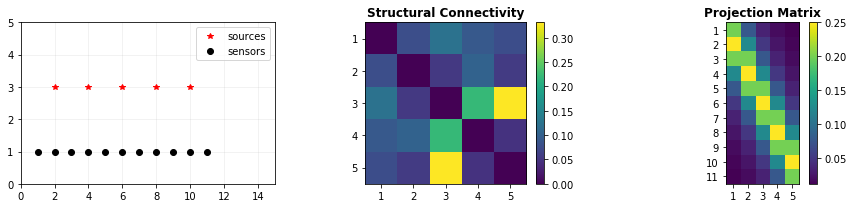

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def gen_con(nNodes):
    '''
        Generates a structural connectivity matrix such that
        the weights follow exponential distribution
    '''
    SC = np.zeros([nNodes,nNodes])
    for i in range(nNodes):
        for j in range(i, nNodes):
            if(i ==j):
                SC[i,j] = 0
            else:      
                SC[i,j] = SC[j,i] = np.random.exponential(0.1)
    return SC

def comp_proj_mat(src_locs,snsr_locs):
    '''
        Compute the projection matrix from sources to sensors
    '''
    nNodes = np.size(src_locs,0)
    nSnsrs = np.size(snsr_locs,0)
    proj_mat = np.zeros([nSnsrs, nNodes])
    for i in range(nSnsrs):
        t = np.linalg.norm(snsr_locs[i,:] - src_locs,ord=None,axis=1)     
        proj_mat[i,:] = 1.0 / t**2
    return proj_mat


np.random.seed(0)

x = np.r_[2:12:2]
y = np.repeat(np.array([3.0]),np.size(x))
src_locs = np.array(list(zip(x,y)))
nNodes = np.size(src_locs,0)
x = np.r_[1:12:1]
y = np.repeat(np.array([1.0]),np.size(x))
snsr_locs = np.array(list(zip(x,y)))
nSnsrs = np.size(snsr_locs,0)


plt.figure(figsize=[12,3])
plt.subplot(131)
plt.plot(src_locs[:,0],src_locs[:,1],'r*',label='sources')
plt.plot(snsr_locs[:,0],snsr_locs[:,1],'ko',label='sensors')
plt.xlim([0,15])
plt.ylim([0,5])
plt.grid(1,alpha=0.2)
plt.legend(loc='upper right')

ax = plt.subplot(132)
SC = gen_con(nNodes)
# SC = np.zeros([nNodes,nNodes])
# SC[4,:] = 0.0
# SC[4,1] = 5.0
# SC[1,4] = 0.05
im = plt.imshow(SC)
plt.xticks(np.arange(0,nNodes),map(str,np.arange(1,nNodes+1)))
plt.yticks(np.arange(0,nNodes),map(str,np.arange(1,nNodes+1)))
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title("Structural Connectivity",fontweight="bold")

proj_mat = comp_proj_mat(src_locs,snsr_locs)

plt.subplot(133)
plt.imshow(proj_mat)
plt.xticks(np.arange(0,nNodes),map(str,np.arange(1,nNodes+1)))
plt.yticks(np.arange(0,nSnsrs),map(str,np.arange(1,nSnsrs+1)))
plt.colorbar(fraction=0.046,pad=0.04)
plt.gca().set_title("Projection Matrix",fontweight="bold")

plt.tight_layout()


np.savez('results/exp1/network.npz', src_locs=src_locs, snsr_locs = snsr_locs, \
        SC=SC, proj_mat=proj_mat)

Simulate the network and store source and seeg log power signals

In [3]:
nn = nNodes
nt = 500
ns = nSnsrs
I1 = 3.1
tau0 = 3.0
gain = proj_mat
sigma = 0.000001
k = 1.0
Ic = np.zeros(nn)

x0 = -2.5*np.ones(nn)
x0[1] = -1.8
x0[4] = -2.2
epsilon_star  = 0.0
amplitude = 1.0
offset = 0.0
time_scale_star = 0.0

x_init = -1.5*np.ones(nn)
z_init = 2.0*np.ones(nn)
z_eta = np.random.normal(0.0, 1.0, [nt-1, nn])

data = {'nn':nNodes, 'nt':nt, 'ns':ns, 'I1':I1, 'tau0':tau0, 
        'gain':gain, 'SC':SC, 'sigma':sigma, 'k':k,
        'x0':x0, 'epsilon_star':epsilon_star,'amplitude':amplitude,
        'offset':offset, 'time_scale_star':time_scale_star,
        'x_init':x_init, 'z_init':z_init, 'z_eta': z_eta,'Ic':Ic}

lib.io.stan.rdump('results/exp1/sim_data.R',data)


# importlib.reload(lib.io.stan)
stan_fname = './vep-fe-rev-08a-fs-sim'
lib.io.stan.create_process(['bash','/home/anirudhnihalani/scripts/stancompile.sh', stan_fname],block=True)
sim_cmd = stan_fname +' sample algorithm=fixed_param num_samples=1 num_warmup=0 data \
file=results/exp1/sim_data.R output file=results/exp1/sim_out.csv'
lib.io.stan.create_process(sim_cmd.split(),block=True)

/home/anirudhnihalani/vep.stan
make: `/home/anirudhnihalani/vep.stan/./vep-fe-rev-08a-fs-sim' is up to date.
method = sample (Default)
  sample
    num_samples = 1
    num_warmup = 0
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.80000000000000004 (Default)
      kappa = 0.75 (Default)
      t0 = 10 (Default)
      init_buffer = 75 (Default)
      term_buffer = 50 (Default)
      window = 25 (Default)
    algorithm = fixed_param
id = 0 (Default)
data
  file = results/exp1/sim_data.R
init = 2 (Default)
random
  seed = 1181601333
output
  file = results/exp1/sim_out.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)

Iteration: 1 / 1 [100%]  (Sampling)

 Elapsed Time: 0 seconds (Warm-up)
               0.05 seconds (Sampling)
               0.05 seconds (Total)



0

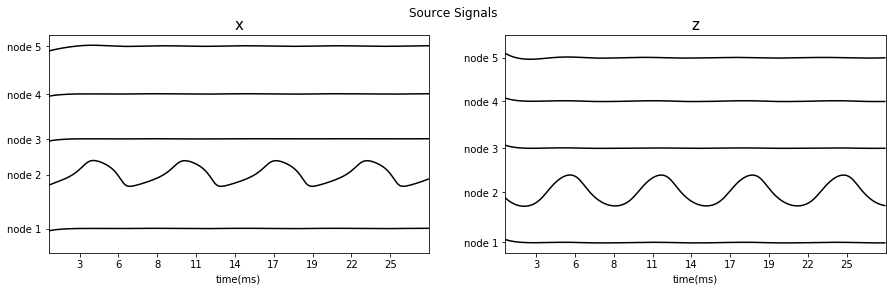

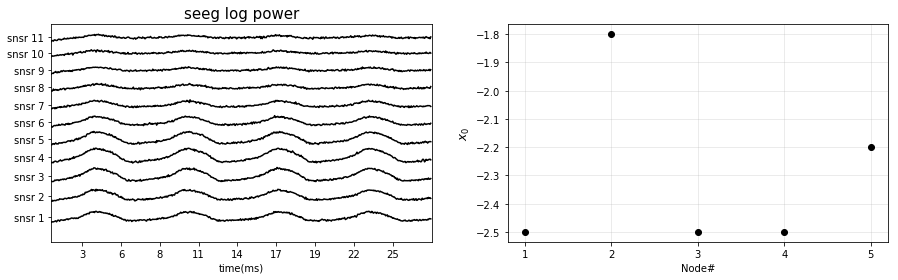

In [4]:
t = lib.io.stan.parse_csv('results/exp1/sim_out.csv')

x = t['x'][0]
z = t['z'][0]
seeglp = t['seeg_log_power'][0]

plt.figure(figsize=[15,4])
plt.subplot(121)
for i in range(nn):
    plt.plot(x.T[:,i]/4.0 + i,label=f'node{i+1}',color='black')
plt.xticks(np.r_[0:nt:50],map(lambda x: '%.0f'%(x) ,np.r_[0:nt:50]*t['time_scale']))
plt.yticks(np.mean(x.T/4.0 + np.arange(nn),axis=0), map(lambda x: f'node {x}',np.arange(1,nn+1)))
plt.xlim([10,500])
plt.xlabel('time(ms)')
plt.gca().set_title('x',fontsize=15.0)
plt.suptitle('Source Signals')
plt.subplot(122)
for i in range(nn):
    plt.plot(z.T[:,i]/4.0 + i,label=f'node{i}',color='black')
plt.xticks(np.r_[0:nt:50],map(lambda x: '%.0f'%(x) ,np.r_[0:nt:50]*t['time_scale']))
plt.yticks(np.mean(z.T/4.0 + np.arange(nn),axis=0), map(lambda x: f'node {x}',np.arange(1,nn+1)))
plt.xlim([10,500])
plt.xlabel('time(ms)')    
plt.gca().set_title('z',fontsize=15.0)

plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
plt.plot(seeglp.T + np.r_[0:2*ns:2],'k')
plt.xticks(np.r_[0:nt:50],map(lambda x: '%.0f'%(x) ,np.r_[0:nt:50]*t['time_scale']))
plt.yticks(np.mean(seeglp.T + np.r_[0:2*ns:2],axis=0), map(lambda x: f'snsr {x}',np.arange(1,ns+1)))
plt.xlim([10,500])
plt.xlabel('time(ms)')
plt.title('seeg log power',fontsize=15.0)
plt.subplot(1,2,2)
plt.plot(np.r_[1:nn+1],x0,'ko')
plt.xlabel('Node#')
plt.xticks(np.arange(1,nn+1),map(str,np.arange(1,nn+1)))
plt.ylabel('$x_0$',fontsize=12.0)
plt.grid(alpha=0.3)


# plt.figure(figsize=[15,3])
# for i in range(nn):
#     plt.subplot(1,5,i+1)
#     plt.plot(x[i,:],'k')
#     plt.xlabel('time')
#     plt.ylabel('x',fontsize=15.0)
#     plt.ylim([-3.0,1.0])
#     plt.gca().set_title(f'node {i+1}')
    
    
# plt.tight_layout()
# plt.figure(figsize=[15,3])
# for i in range(nn):
#     plt.subplot(1,5,i+1)
#     plt.plot(z[i,:],'k')
#     plt.xlabel('time')
#     plt.ylabel('z',fontsize=15.0)
# #     plt.ylim([0,5.0])
#     plt.gca().set_title(f'node {i+1}')
# plt.tight_layout()


In [5]:
# plt.figure(figsize=[10,4])
# plt.subplot(121)
# plt.plot(x[[1,4],:].T)
# plt.subplot(122)
# plt.plot(z[[1,4],:].T)
# plt.figure(figsize=[10,4])
# plt.subplot(121)
# plt.plot(x[1,:])
# plt.plot(z[1,:])
# plt.subplot(122)
# plt.plot(x[4,:])
# plt.plot(z[4,:])
# plt.figure(figsize=[10,4])
# plt.subplot(121)
# plt.plot(x[1,:],z[1,:],'x')
# plt.subplot(122)
# plt.plot(x[4,:],z[4,:],'x')

# plt.figure()
# plt.plot(x[1,:])
# plt.plot(z[4,:])

Fit the simulated data

In [6]:
# compile the stan file
lib.io.stan.create_process(['bash','/home/anirudhnihalani/scripts/stancompile.sh', \
                            './vep-fe-rev-08a-fs'],block=True)
nchains = 8
for max_depth in range(5,16):
    for i in range(1,ns+1):
        # select data for fitting from the simulated data and dump 
        # it to a R file
        data = {'nn':nn, 'nt':nt, 'ns': i, 'I1': I1, 'tau0': tau0, \
                'gain': proj_mat[0:i,:], 'seeg_log_power':seeglp[0:i,:].T, \
                'Ic':Ic, 'SC': SC, 'sigma':sigma, 'k':k}
        lib.io.stan.rdump(f'results/exp1/fit_data_ns{i}.R',data)
        with open('src-snsr-gmtry.sh','r') as fd:
            job_str = fd.read()
        slurm_script = f'tmp/ns{i}_md{max_depth}.sh'
        with open(slurm_script, 'w') as fd:
            fd.write(job_str.format(i,nchains,max_depth))

        lib.io.stan.create_process(['sbatch',slurm_script],block=False)


/home/anirudhnihalani/vep.stan
make: `/home/anirudhnihalani/vep.stan/./vep-fe-rev-08a-fs' is up to date.


Compute the convergence statistics i.e. $\hat r$ across chains

In [ ]:
stan_dir = '/home/anirudhnihalani/soft/cmdstan-2.17.0/bin'
results_dir = './results/exp1'


# # Remove warmup samples before computing r-hat
# num_warmup_samples = 200
# ns = 11
# nchains = 8
# max_depth = 12

# for k in range(8,max_depth+1):
#     for i in range(1,ns+1):
#         for j in range(1,nchains+1):
#             src_fname = f'{results_dir}/fitout_ns{i}_md{k}_chain{j}.csv'
#             if(os.path.isfile(src_fname)):
#                 trgt_fname = f'{results_dir}/fitout_ns{i}_md{k}_chain{j}_wowarmup.csv'
#                 lib.io.stan.rem_warmup_samples(src_fname,trgt_fname,num_warmup_samples)
#             else:
#                 print(f'File not found: {src_fname}')

rhats = np.zeros([max_depth, ns, nn])                
# Compute rhat
for k in range(8,max_depth+1):
    for i in range(1,ns+1):
        csv_files = ' '.join([f'{results_dir}/fitout_ns{i}_md{k}_chain{j}_wowarmup.csv' \
                              for j in range(1,nchains+1)])
        cmd = f'{stan_dir}/stansummary \
                --csv_file={results_dir}/summary_ns{i}_md{k}.csv \
                {csv_files}'
        stdout = open('/dev/null','ab')
        lib.io.stan.create_process(cmd.split(),block=True,stdout=stdout)
        t = lib.io.stan.parse_summary_csv(f'{results_dir}/summary_ns{i}_md{k}.csv')
        rhats[k-8,i-1,:] = t[1]['x0'][:,-1]
np.save(f'{results_dir}/converge_stats.npy',rhats)

Plot of $\hat r$ as a function of #sensors that are used for inference

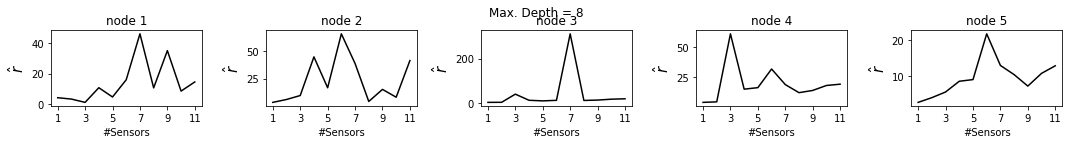

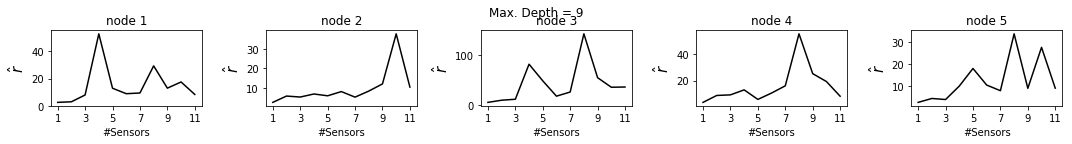

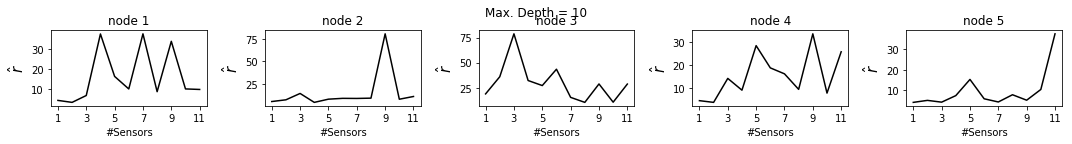

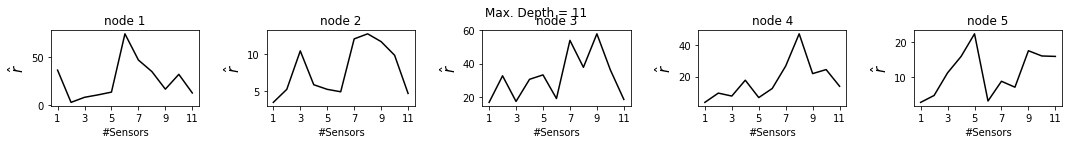

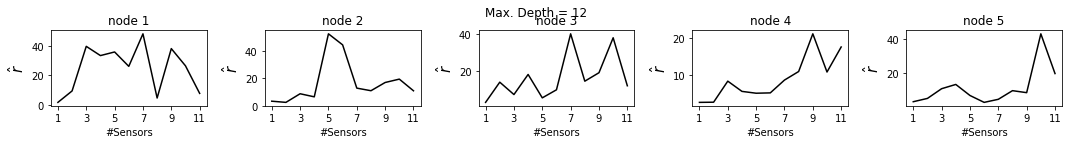

In [89]:
rhats = np.load('results/exp1/converge_stats.npy')
for k in range(8,max_depth+1):
    plt.figure(figsize=[15,2])
    for i in range(1,nn+1):
        plt.subplot(1,5,i)
        plt.plot(np.r_[1:12],rhats[k-8,:,i-1],'k')
        plt.xticks(np.r_[1:12:2],np.r_[1:12:2])
        plt.xlabel('#Sensors')
        plt.ylabel('$\hat r$',fontsize=15)
        plt.gca().set_title(f'node {i}')
    plt.suptitle(f'Max. Depth = {k}')
    plt.tight_layout()
    

    